* Pima Indians Diabetes Dataset
* The Pima Indians Diabetes Dataset involves predicting the onset of diabetes within 5 years in Pima Indians given medical details.
* It is a binary (2-class) classification problem. The number of observations for each class is not balanced. There are 768 observations with 8 input variables and 1 output variable. Missing values are believed to be encoded with zero values. The variable names are as follows:
* Number of times pregnant.
* Plasma glucose concentration a 2 hours in an oral glucose tolerance test.
* Diastolic blood pressure (mm Hg).
* Triceps skinfold thickness (mm).
* 2-Hour serum insulin (mu U/ml).
* Body mass index (weight in kg/(height in m)^2).
* Diabetes pedigree function.
* Age (years).
* Class variable (0 or 1).

In [ ]:
# Kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from numpy.linalg import eig
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import warnings
warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
df_ = pd.read_csv('/kaggle/input/veri-seti/veri-seti.txt', delimiter = "\t", header=None)
df = df_.copy()
df.columns = ["pregnant", "glucose", "bloodpressure", "skinthickness", "insulin", "bmi", "diabetespedigreefunction", "age", "outcome"]
df.head()

df.describe().T # Genel bakış yapıldı

# pregnant değişkeeninin max değeri 17 aykırı olabilir, fakat yaş değişkeni ile beraber incelenip aykırı değer incelenebilir. Eğer 18 yaşında 17 hamilelik sayısı var ise hatalı değerdir.
# glucose, bloodpressure, skinthickness, insulin, bmi değerleri 0 olamaz.
# glucose değeri 0-25 lik çeyrek arasında büyük atlayış var. Diğer 25'lik çeyreklik artışları normal.
# insulin: çeyreklik değerler incelendiğinde geniş yayılım söz konusu ve yüzde 75'lik çeyrek ile max değeri arası çok fazla, aykırılık incelenebilir.
# insulin: ortalama 79, median 30, sola çarpıklık söz konusu

,count,mean,std,min,25%,50%,75%,max
pregnant,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
bloodpressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
skinthickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
bmi,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
diabetespedigreefunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


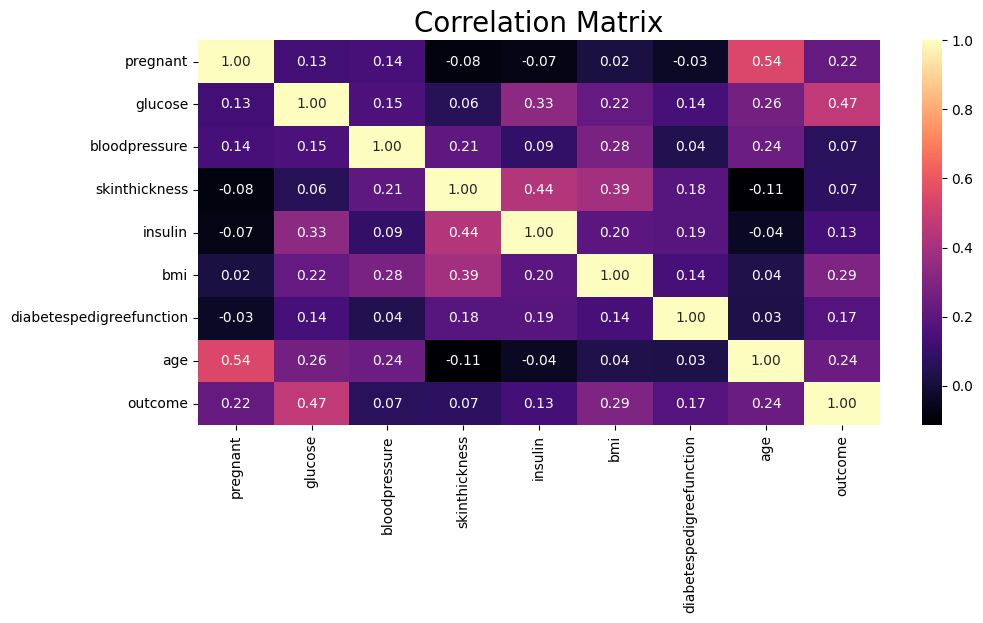

In [ ]:
# Korelasyon Matrisi

f, ax = plt.subplots(figsize=[11, 5])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

# iki değişken arasında pozitif bir ilişki olduğunu gösterir:
# yaş ~ hamilelik sayısı
# glucose ~ outcome
# skinthickness ~ insulin
# bu değişkenler ile yeni değişkenler türetilebilir feature engineering kısmı için

In [ ]:
# Pregnancies ve Outcome dışındaki değişken değerleri 0 olamayacağı bilinmektedir.
# 0 olan değerlere NaN atanabilir .

zero = [col for col in df.columns if (df[col].min() == 0 and col not in ["pregnant", "outcome"])]

# Gözlem birimlerinde 0 olan degiskenlerin her birisine gidip 0 iceren gozlem degerlerini NaN ile değiştirdik.

for col in zero:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

df.isnull().sum()

pregnant                      0
glucose                       5
bloodpressure                35
skinthickness               227
insulin                     374
bmi                          11
diabetespedigreefunction      0
age                           0
outcome                       0
dtype: int64

In [ ]:
# Eksik verilerin dataframe içerisindeki yüzdesine bakıyoruz
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum()>0]                     # boş değer içeren sütunlar eklendi
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)                             # boş değer sayısı büyükten küçüğe sıralandı
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False) # dataframe için boş değerlerin yüzdesi hesaplandı
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values_table(df, True)

# insulin değeri df'in yüzde 50'sini oluşturmakta.

               n_miss  ratio
insulin           374 48.700
skinthickness     227 29.560
bloodpressure      35  4.560
bmi                11  1.430
glucose             5  0.650


In [ ]:
# Eksik Değerlerin Bağımlı Değişken ile İlişkisinin İncelenmesi
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_'] = np.where(temp_df[col].isnull(), 1, 0) # eksik değerlere 1 atandı ve yeni değişken oluşturuldu
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns  # eksik olan yeni değişkenler tutuldu
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(), # eksik değerlerin hedef değişkene göre ortalaması alındı
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

missing_vs_target(df, "outcome", na_columns)

# count miktarları yakın olmamakla birlikte hedef değişkene göre ortalamalar birbirine yakın. Kesin yorumlar yapılmayabilir fikir sağlayabilir
# glucose değeri eksik olan kişilerin diyabet değişkeninin ortalaması biraz yüksek
# bloodpresure değişkeninde eksiklikler gözlemlenen kişilerin diyabet olma ortalaması biraz yüksek.
# .
# .
# .

             TARGET_MEAN  Count
glucose_NA_                    
0                  0.349    763
1                  0.400      5


                   TARGET_MEAN  Count
bloodpressure_NA_                    
0                        0.344    733
1                        0.457     35


                   TARGET_MEAN  Count
skinthickness_NA_                    
0                        0.333    541
1                        0.388    227


             TARGET_MEAN  Count
insulin_NA_                    
0                  0.330    394
1                  0.369    374


         TARGET_MEAN  Count
bmi_NA_                    
0              0.351    757
1              0.182     11




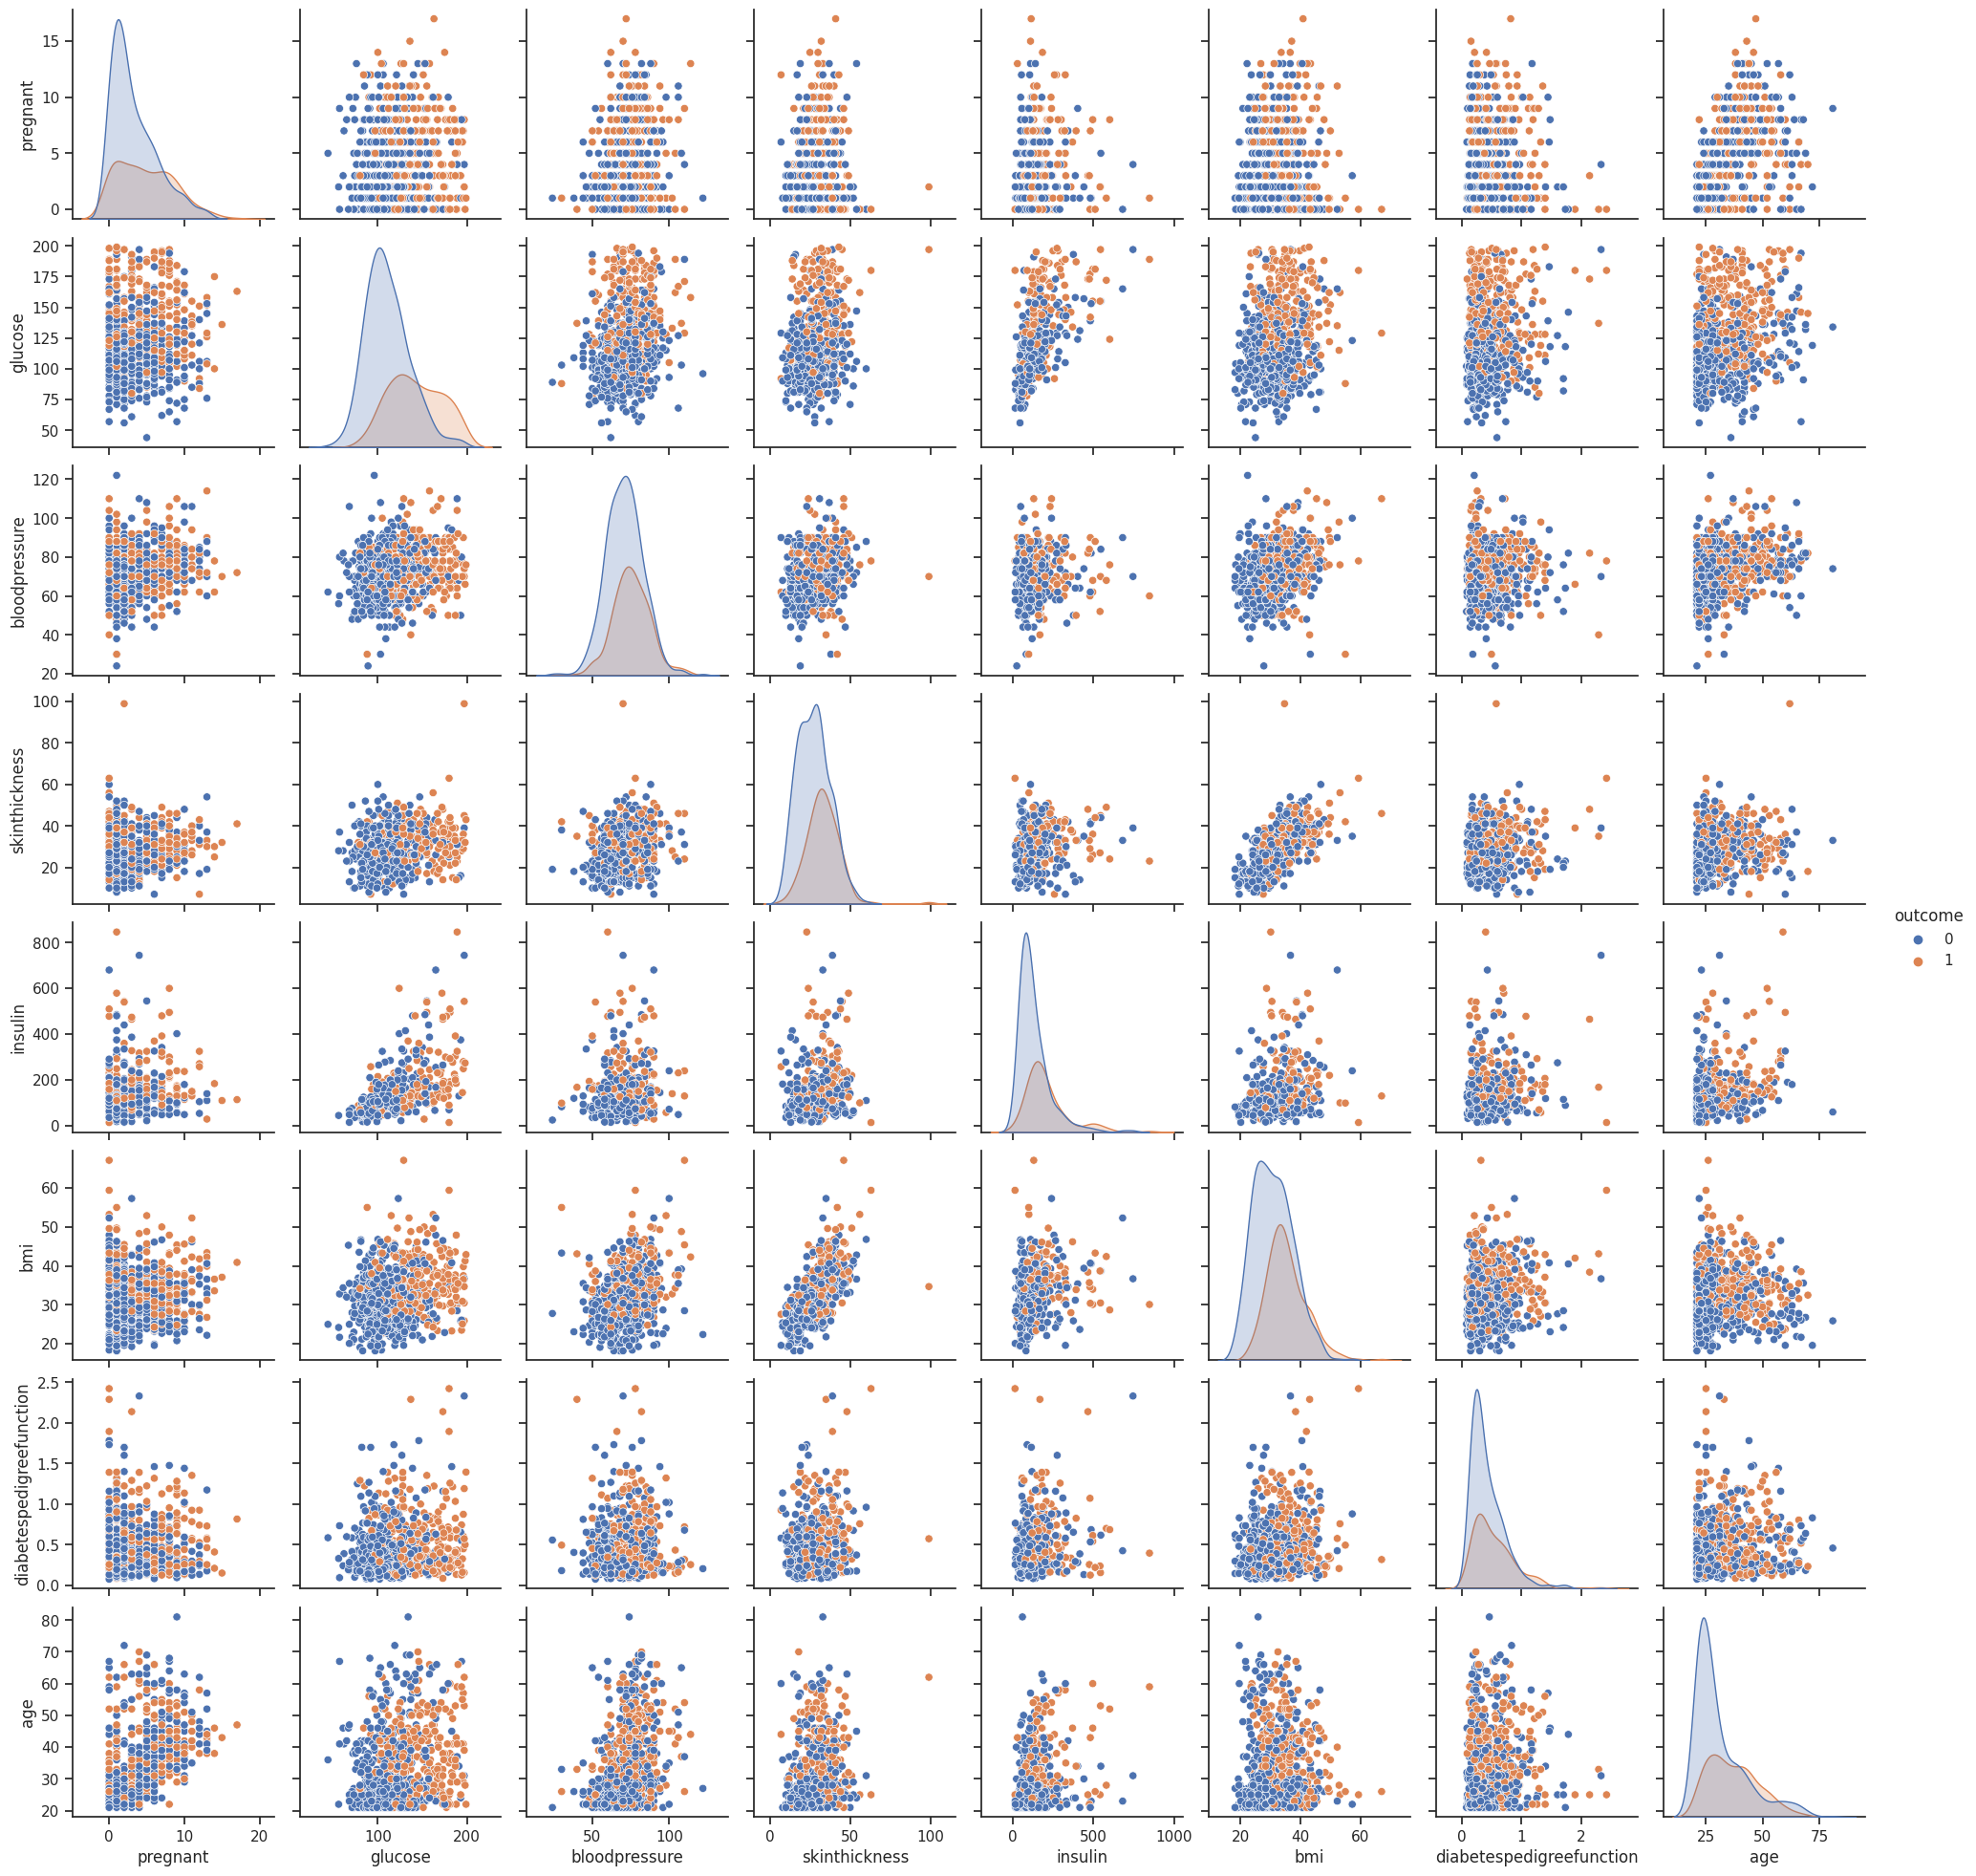

In [ ]:
sns.set(style="ticks")
sns.pairplot(df, hue="outcome")
# her ikili değişkenin grafiği oluşturuldu
# bazı grafiklerde turuncu noktalar ile mavi noktalar sınıflandırılmaya yakın şekilde ayırt edilebiliyor.
# glucose değişkeni ile diğer grafiklere bakarsak hedef değişkenimiz için önemli değişkenlerden olabilir

In [ ]:
# Eksik değerlerin median ile dolduruldu

for col in zero:
    df.loc[df[col].isnull(), col] = df[col].median()

df.isnull().sum()

pregnant                    0
glucose                     0
bloodpressure               0
skinthickness               0
insulin                     0
bmi                         0
diabetespedigreefunction    0
age                         0
outcome                     0
dtype: int64

# Aykırı Değer İçin Metodlar

# Z-SCORE METODU

<img src="attachment:9fc24d01-885f-4697-9866-f6a59addea7d.png" width="500">

* Z-score Formül

* Zscore=X−Ortalama/(Standart Sapma)




# IQR - METODU

<img src="attachment:5fb8b182-93c0-4647-a095-5894fe6cb7c7.png" width="500">

* min_quartile = quartile1 - 1.5 * interquantile_range

* max_quartile = quartile3 + 1.5 * interquantile_range

In [ ]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95): # geçerli kolon için aykırı değerler için alt ve üst limit oluşturuldu
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name): # seçili kolonda aykırı değer kontrolü  yapan fonksiyon
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


for col in df.columns:
    print(col, check_outlier(df, col))

# Outlier tespit edildi fakat baskılama veya silinmedi, probleme göre baskılanır, silinebilir.
# skinthickness, insulin değişkenlerinde belirlediğimiz limitlere göre aykırı değer bulundu


# Aykırı değerleri baskılamak isterseniz aşağıdaki kod satırlarını çalıştırabilirsiniz.
"""
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit



# Aykırı değer analizi ve baskılama işlemi

for col in df.columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

for col in df.columns:
    print(col, check_outlier(df, col))"""

pregnant False
glucose False
bloodpressure False
skinthickness True
insulin True
bmi False
diabetespedigreefunction False
age False
outcome False


# Feature Engineering

In [ ]:
df.head()

,pregnant,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1


In [ ]:
# Hamilelik geçirip obez olanlar ve olmayanlar
df.loc[(df["pregnant"] > 0) & (df["bmi"] >= 30), "PregnantBMI"] = "PregnantandObesite"
df.loc[(df["pregnant"] > 0) & (df["bmi"] < 30), "PregnantBMI"] = "Pregnantandfit"
df.loc[(df["pregnant"] == 0) & (df["bmi"] < 30), "PregnantBMI"] = "NotPregnantandfit"
df.loc[(df["pregnant"] == 0) & (df["bmi"] >= 30), "PregnantBMI"] = "NotPregnantandObesite"

# Hamile ve glukozu yüksek olanlar ve olmayanlar
df.loc[(df["pregnant"] > 0) & (df["glucose"] >= df["glucose"].mean()), "PregnantGlucose"] = "PregnantHighG"
df.loc[(df["pregnant"] > 0) & (df["glucose"] < df["glucose"].mean()), "PregnantGlucose"] = "PregnantLowG"
df.loc[(df["pregnant"] == 0) & (df["glucose"] < df["glucose"].mean()), "PregnantGlucose"] = "NotPregnantLowG"
df.loc[(df["pregnant"] == 0) & (df["glucose"] >= df["glucose"].mean()), "PregnantGlucose"] = "NotPregnantHighG"

# Insulin * BMI / SkinThickness
df["IxBMI/ST"] = df["insulin"] * df["bmi"] / df["skinthickness"]

# Glucose * BloodPressure / SkinThickness
df["GxBP/ST"] = df["glucose"] * df["bloodpressure"] / df["skinthickness"]

# DiabetesPedigreeFunction * Age / IxBMI/ST
df["DPFxAGE/IxBMI/ST"] = df["diabetespedigreefunction"] * df["age"] / df["IxBMI/ST"]

# Pregnancies / Glucose * log(SkinThickness)
df["P/GxlogST"] = df["pregnant"] / df["glucose"] * np.log(df["skinthickness"])

# Yaş değişkenini kategorilere ayırıp yeni yaş değişkeni oluşturulması
df.loc[(df["age"] >= 21) & (df["age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["age"] >= 50), "NEW_AGE_CAT"] = "senior"

# BMI 18,5 aşağısı underweight, 18.5 ile 24.9 arası normal, 24.9 ile 29.9 arası Overweight ve 30 üstü obez
df["NEW_BMI"] = pd.cut(x=df["bmi"], bins=[0, 18.5, 24.9, 29.9, 100], labels=["Underweight", "Healthy", "Overweight", "Obese"])

# Glukoz degerini kategorik değişkene çevirme
df["NEW_GLUCOSE"] = pd.cut(x=df["glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])

# Yaş ve beden kitle indeksini bir arada düşünerek kategorik değişken oluşturma 3 kırılım yakalandı
df.loc[(df["bmi"] < 18.5) & ((df["age"] >= 21) & (df["age"] < 50)), "NEW_AGE_BMI_NOM"] = "underweightmature"
df.loc[(df["bmi"] < 18.5) & (df["age"] >= 50), "NEW_AGE_BMI_NOM"] = "underweightsenior"

df.loc[((df["bmi"] >= 18.5) & (df["bmi"] < 25)) & ((df["age"] >= 21) & (df["age"] < 50)), "NEW_AGE_BMI_NOM"] = "healthymature"
df.loc[((df["bmi"] >= 18.5) & (df["bmi"] < 25)) & (df["age"] >= 50), "NEW_AGE_BMI_NOM"] = "healthysenior"

df.loc[((df["bmi"] >= 25) & (df["bmi"] < 30)) & ((df["age"] >= 21) & (df["age"] < 50)), "NEW_AGE_BMI_NOM"] = "overweightmature"
df.loc[((df["bmi"] >= 25) & (df["bmi"] < 30)) & (df["age"] >= 50), "NEW_AGE_BMI_NOM"] = "overweightsenior"

df.loc[(df["bmi"] >= 30) & ((df["age"] >= 21) & (df["age"] < 50)), "NEW_AGE_BMI_NOM"] = "obesemature"
df.loc[(df["bmi"] >= 30) & (df["age"] >= 50), "NEW_AGE_BMI_NOM"] = "obesesenior"

# Yaş ve Glikoz değerlerini bir arada düşünerek kategorik değişken oluşturma
df.loc[(df["glucose"] < 70) & ((df["age"] >= 21) & (df["age"] <50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
df.loc[(df["glucose"] < 70) & (df["age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"

df.loc[((df["glucose"] >= 70) & (df["glucose"] < 100)) & ((df["age"] >= 21) & (df["age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
df.loc[((df["glucose"] >= 70) & (df["glucose"] < 100)) & (df["age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"

df.loc[((df["glucose"] >= 100) & (df["glucose"] < 125)) & ((df["age"] >= 21) & (df["age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
df.loc[((df["glucose"] >= 100) & (df["glucose"] < 125)) & (df["age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"

df.loc[(df["glucose"] >= 125) & ((df["age"] >= 21) & (df["age"] <50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
df.loc[(df["glucose"] >= 125) & (df["age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"

# İnsulin Değeri ile Kategorik değişken türetmek
def set_insulin(dataframe, col_name="insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"

df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis=1)

df["NEW_GLUCOSE*INSULIN"] = df["glucose"] * df["insulin"]

df["NEW_GLUCOSE*PREGNANCIES"] = df["glucose"] * (1+ df["pregnant"])

# BMI * GLUCOSE
df["BMIXGLUCOSE"] = df["bmi"] * df["glucose"]

# HOMA-IR (Homeostatic Model Assessment of Insulin Resistance), insülin direncini değerlendirmek için kullanılan bir indekstir ve Glucose (kan şekeri) ile insülin düzeylerine dayalı bir hesaplama ile elde edilir.
# HOMA-IR = (Fasting Insulin (mU/L) x Fasting Glucose (mmol/L)) / 22.5
df["HOMA-IR"] = (df["insulin"] * df["glucose"]) / 22.5

# İnsülin Sensitivitesi İndeksi
# İnsülin duyarlılığı indeksi, bir kişinin vücudunun insülini ne kadar iyi kullanabildiğini ölçen bir indekstir.
# QUICKI = 1 / (log(Insulin μU/mL) + log(Glucose mg/dL))
# QUICKI = 1 / (log(10) + log(90)) ≈ 0.375

df["QUICKI"] = 1 / (np.log(df["insulin"]) + np.log(df["glucose"]))

# Encoding

In [ ]:
# Numerik ve kategorik değişkenlein yakalanması

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)


# LABEL ENCODING

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_col = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

for col in binary_col:
    df = label_encoder(df, col)


# One-Hot Encoding İşlemi

cat_cols = [col for col in cat_cols if col not in binary_col and col not in ["outcome"]]

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

Observations: 768
Variables: 26
cat_cols: 9
num_cols: 17
cat_but_car: 0
num_but_cat: 3


# LDA (Linear Discriminant Analysis)

Accuracy : 0.7445887445887446


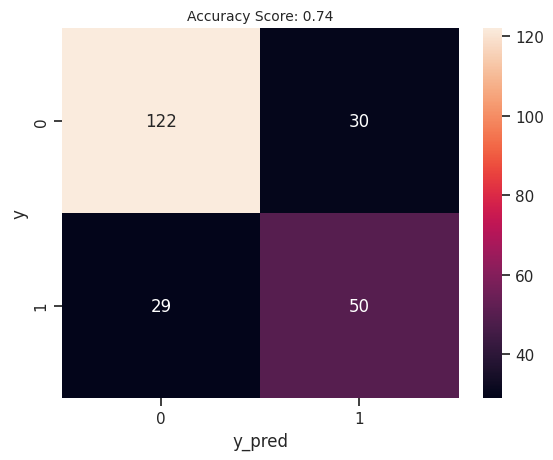

LDA Sensitivity: 0.6329113924050633
LDA Specificity: 0.8026315789473685


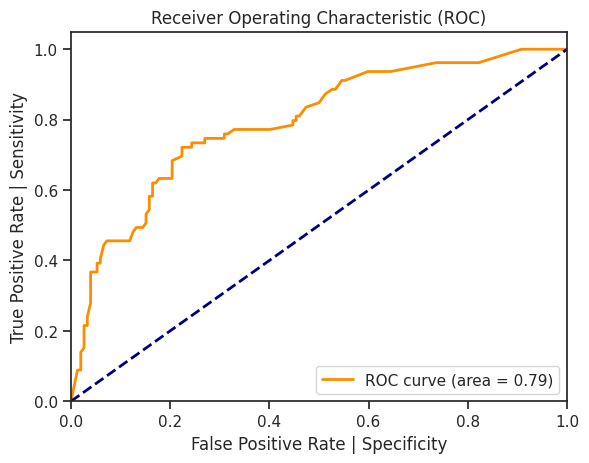

In [ ]:
X = df.drop(columns=["outcome"])
y = df["outcome"]
X = StandardScaler().fit_transform(X) # Normalizasyon yapıldı
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=106) # veri seti train ve test seti olcak şekilde ayrıldı
lda = LinearDiscriminantAnalysis()
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

LinearDiscriminantAnalysis().get_params()# LDA fonksiyonunun hiperparametreleri
dir(LinearDiscriminantAnalysis()) # LDA fonksiyonları getirilir

##################################******************###################################################

# Random Forest
classifier = RandomForestClassifier(max_depth=3, random_state=0)
RandomForestClassifier().get_params()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print('Accuracy : ' + str(accuracy_score(y_test, y_pred))) # 0.74

##################################******************###################################################

# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred):
    acc = round(accuracy_score(y_test, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y_test, y_pred)

##################################******************###################################################

# sensitivity, specificity hesaplama fonksiyonu
def calculate_sensitivity_specificity(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    return sensitivity, specificity

sensitivity, specificity = calculate_sensitivity_specificity(y_test, y_pred)
print("LDA Sensitivity:", sensitivity) # 0.63
print("LDA Specificity:", specificity) # 0.80

##################################******************###################################################

# Tahmin olasılıklarını alarak ROC eğrisini hesaplama
y_pred_proba = classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC eğrisini çizme
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate | Specificity')
plt.ylabel('True Positive Rate | Sensitivity')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Çoklu Doğrusal Regresyon analizi ve Multinominal Lojistik Regresyon

variance:  [0.21451222 0.12402217] 

sum:  0.33853438824891025
LOGISTIC REGRESSION ACC:  0.77


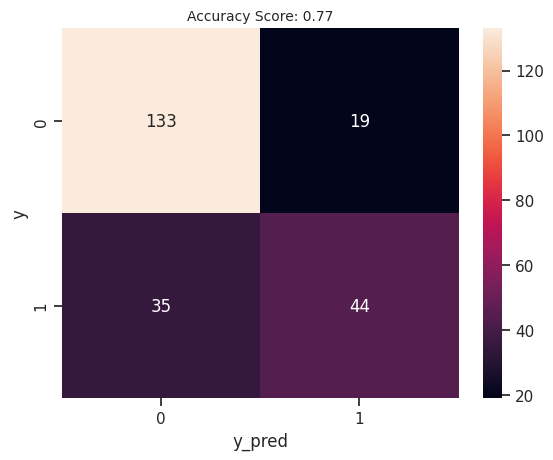

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       152
           1       0.70      0.56      0.62        79

    accuracy                           0.77       231
   macro avg       0.75      0.72      0.73       231
weighted avg       0.76      0.77      0.76       231



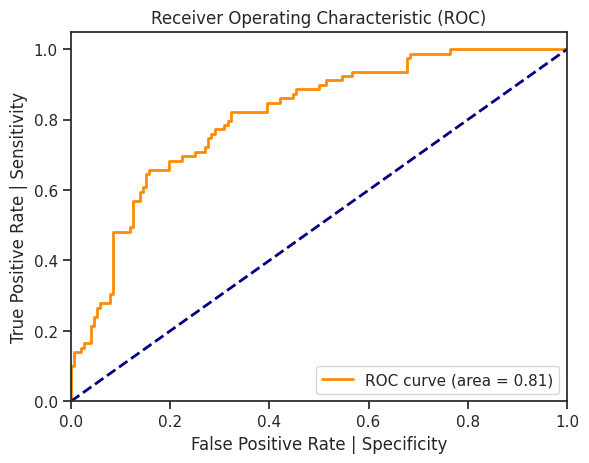

Model katsayıları:  [[0.43043634 0.02343286]]
Acc:  0.746680642907058
F1:  0.6013641802336499
ROC-AUC:  0.811846282372598
Logistick Reg Sensitivity: 0.5569620253164557
Logistick Reg Specificity: 0.875
LOGISTIC REGRESSION ACC:  0.79


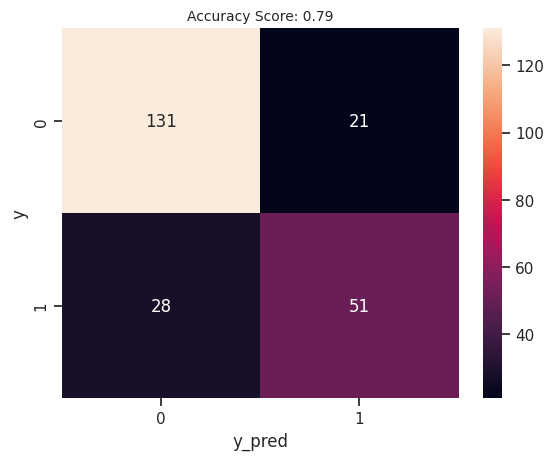

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       152
           1       0.71      0.65      0.68        79

    accuracy                           0.79       231
   macro avg       0.77      0.75      0.76       231
weighted avg       0.78      0.79      0.79       231



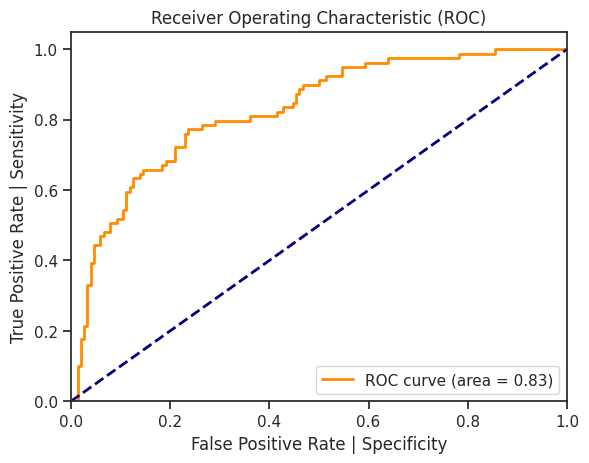

Model katsayıları:  [[ 0.63954924  1.1840755  -0.07167149 -0.18155351  0.06951165 -0.05891445
   0.2003842   0.52387663  0.0300195  -0.22467926  0.06954497 -0.03236993
  -0.07474869  0.08521602 -0.3320422  -0.38131926  0.55406017 -0.3320422
  -0.88074206 -0.04792324 -0.16526414 -0.19206448 -0.09018764 -0.23002714
  -0.12313849  0.14171307  0.21795821 -0.03427298  0.1565391  -0.20569912
  -0.14660002 -0.09381946 -0.10826851  0.00523357 -0.24111343 -0.08638373
  -0.14840692 -0.07665248 -0.34228273  0.06395284  0.20632484 -0.2508827
   0.        ]]
Acc:  0.7597833682739343
F1:  0.6375466275466275
ROC-AUC:  0.8147510934198241
Logistick Reg Sensitivity: 0.6455696202531646
Logistick Reg Specificity: 0.8618421052631579


In [ ]:
# Train - Test Split
X = df.drop(columns=["outcome"])
y = df["outcome"]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=106)

##################################************************##################################

#PCA
pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train, y_train)
X_test = pca.transform(X_test)
print("variance: ", pca.explained_variance_ratio_, "\n") # 0.21, 0.12 en yüksek iki öznitelik
print("sum: ", sum(pca.explained_variance_ratio_)) # 0.33 Toplam

##################################************************##################################

# Multinominal Lojistik Regresyon
log_model = LogisticRegression().fit(X_train, y_train) # Model kuruldu ve eğitildi

# Model Validation: 10-Fold Cross Validation           # 10 katlı cv yöntemi kullanıldı
cv_results = cross_validate(log_model,
                            X_train, y_train,
                            cv=10,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

# Predict
y_pred = log_model.predict(X_test)
print("LOGISTIC REGRESSION ACC: ", round(accuracy_score(y_test, y_pred), 2)) # 0.77 ACC

##################################************************##################################

# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred):
    acc = round(accuracy_score(y_test, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y_test, y_pred)

##################################************************##################################

# Başarı skorları:
print(classification_report(y_test, y_pred))

# presicion  0.70 doğrulukla pozitif olarak tahminlediğimiz değerlerin gerçekten kaç adedinin pozitif olduğunu göstermektedir.
# recall  0.56 ile pozitif olarak tahmin etmemiz gereken işlemlerin ne kadarını pozitif olarak tahmin ettiğimizi gösteren bir metriktir.
# f1 score 0.62 testin doğruluğunun bir ölçüsüdür —kesinlik ve duyarlılığın harmonik ortalamasıdır.

# ROC AUC
y_prob = log_model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_prob)

# 0.81 Modelleri sınıflar arasında ne kadar ayırt edebildiğini anlatır. AUC yükseldikçe, model tahmin etmede daha iyi demektir.

##################################************************##################################

# Tahmin olasılıklarını alarak ROC eğrisini hesaplama
y_pred_proba = log_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC eğrisini çizme
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate | Specificity')
plt.ylabel('True Positive Rate | Sensitivity')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

##################################************************##################################

# 10 Katlı CV Model katsayıları
print("Model katsayıları: ", log_model.coef_)
# ACC,F1,ROC/AUC
print("Acc: ",cv_results['test_accuracy'].mean())
print("F1: ",cv_results['test_f1'].mean())
print("ROC-AUC: ",cv_results['test_roc_auc'].mean())

# Model katsayıları:  [[0.43043635 0.02343269]]
# Acc:  0.74
# F1:  0.60
# ROC-AUC:  0.81

##################################************************##################################

def calculate_sensitivity_specificity(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    return sensitivity, specificity
sensitivity, specificity = calculate_sensitivity_specificity(y_test, y_pred)
print("Logistick Reg Sensitivity:", sensitivity)
print("Logistick Reg Specificity:", specificity)

# Logistick Reg Sensitivity: 0.55
# Logistick Reg Specificity: 0.87

##################################************************##################################



################################## PCA YAPILMADAN KURULAN MODEL##################################

# Train - Test Split
X = df.drop(columns=["outcome"])
y = df["outcome"]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=106)

##################################************************##################################

# Multinominal Lojistik Regresyon
log_model = LogisticRegression().fit(X_train, y_train)

# Model Validation: 10-Fold Cross Validation
cv_results = cross_validate(log_model,
                            X_train, y_train,
                            cv=10,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

# Predict
y_pred = log_model.predict(X_test)
print("LOGISTIC REGRESSION ACC: ", round(accuracy_score(y_test, y_pred), 2))

# Before ACC 0.77
# After ACC 0.79
# Pca yapılmadığı modelde Accuracy değerimiz arttı.

##################################************************##################################

# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred):
    acc = round(accuracy_score(y_test, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y_test, y_pred)

##################################************************##################################

# Başarı skorları:
print(classification_report(y_test, y_pred))

# before presicion 0.70
# before recall 0.56
# before f1 score 0.62

# after presicion 0.71
# after recall 0.65
# after f1 score 0.68

# ROC AUC
y_prob = log_model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_prob)

# before 0.81
# after 0.82

# PCA yapılmadığında precision ve recall değerinde değişiklikler var. 2 değişken ile precision değeri 0.70 iken pca yapılmadan uygulanan modelde 0.71.
# İki modeli kıyaslamak için F1 score'a bakılabilir. PCA yapılmaz ise 0.68 çıkıyor.
# Roc-Auc değerinde büyük değişiklikler gözlemlenmedi

##################################************************##################################

# Tahmin olasılıklarını alarak ROC eğrisini hesaplama
y_pred_proba = log_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC eğrisini çizme
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate | Specificity')
plt.ylabel('True Positive Rate | Sensitivity')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

##################################************************##################################

# 10 Katlı CV Model katsayıları
print("Model katsayıları: ", log_model.coef_)

# ACC,F1,ROC/AUC
print("Acc: ",cv_results['test_accuracy'].mean())
print("F1: ",cv_results['test_f1'].mean())
print("ROC-AUC: ",cv_results['test_roc_auc'].mean())

# before Acc:  0.74
# before F1:  0.60
# before ROC-AUC:  0.81

# after Acc:  0.75
# after F1:  0.63
# after ROC-AUC:  0.81

# PCA yöntemi uygulanmadığı takdirde büyük artışlar olmadı.

##################################************************##################################

def calculate_sensitivity_specificity(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    return sensitivity, specificity
sensitivity, specificity = calculate_sensitivity_specificity(y_test, y_pred)
print("Logistick Reg Sensitivity:", sensitivity)
print("Logistick Reg Specificity:", specificity)

# before Logistick Reg Sensitivity: 0.55
# before Logistick Reg Specificity: 0.87

# after Logistick Reg Sensitivity: 0.64
# after Logistick Reg Specificity: 0.86

# Sensitivity'nin artması modelde istediğimiz bir şey. PCA uygulanmadığı zaman doğru diyabet hasta teşhisi artmakta.

##################################************************##################################

# Doğruluk(Accuracy), doğru olarak sınıflandırılan örneklerin yüzdesidir. PCA'siz yöntemde accuracy arttı.
# Duyarlılık(Recall), pozitif olarak tahmin etmemiz gereken işlemlerin ne kadarını pozitif olarak tahmin ettiğimizi gösteren bir metriktir. PCA'siz yöntemde recall değeride arttı.
# Kesinlik(precision), pozitif olarak tahminlediğimiz değerlerin gerçekten kaç adedinin pozitif olduğunu göstermektedir. PCA'siz yöntem ile kurulan modelde precision değeri az arttı.
# Hassasiyet (Sensitivity) bize diyabet hastalığı olan insanların yüzde kaçının gerçekte doğru olarak tanımlandığını söyler. PCA'siz yöntemde Hassasiyet konusunda büyük artış sağlandı.
# Specifity (Özgüllük) bize diyabet hastalığı olmayan insanların yüzde kaçının gerçekte doğru bir şekilde tanımlandığını söyler. PCA'siz yöntem ile özgüllük değerimizde de büyük artış sağlandı.
# F1 skoru, bir testin doğruluğunun bir ölçüsüdür —kesinlik ve duyarlılığın harmonik ortalamasıdır. Son kurulan modelde F1 skorumuz arttı.
# Pozitifleri doğru bir şekilde tanımlamak bizim için önemliyse, daha yüksek Hassasiyetli bir model seçmeliyiz.

# Before ACC: 0.77
# After ACC: 0.79

# Before Recall: 0.56
# After Recall: 0.65

# Before Precision: 0.70
# After Precision: 0.71

# Before F1: 0.62
# After F1: 0.68

# Before ROC AUC: 0.81
# After ROC AUC: 0.81

# Before Sensitivity: 0.55
# After Sensitivity: 0.87

# Before Specificity: 0.74
# After Specificity: 0.86

# PCA ile PCA'siz yöntem ile karşılaştırmaların doğruluğunu kabul etmek için hipotez testi kurulmalı.
# İki yöntemin farkı rastgele oluşan bir farklılık mı yoksa anlamlı bir farklılık mı kontrol edilmeli.


# Karar Ağaçları: RANDOM FORESTS

In [ ]:
# Train - Test Split
X = df.drop(columns=["outcome"])
y = df["outcome"]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=106)

##################################************************##################################

#PCA
pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train, y_train)
X_test = pca.transform(X_test)
print("variance: ", pca.explained_variance_ratio_, "\n") # 0.21, 0.12 en yüksek iki öznitelik
print("sum: ", sum(pca.explained_variance_ratio_)) # 0.33 toplam

##################################************************##################################

# Random Forests
rf_model = RandomForestClassifier(random_state=10)
rf_model.get_params()

# Model Validation: 10-Fold Cross Validation
cv_results = cross_validate(rf_model, X_train, y_train, cv=10, scoring=["accuracy", "f1", "roc_auc"])
print("Acc: ",cv_results['test_accuracy'].mean()) #0.67
print("F1: ",cv_results['test_f1'].mean()) #0.53
print("ROC-AUC: ",cv_results['test_roc_auc'].mean()) #0.74

rf_params = {"max_depth": [5, 8],
             "max_features": [3, 5],
             "min_samples_split": [5, 8, 15],
             "n_estimators": [200, 500]}

# Model Tunning
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X_train, y_train)
rf_best_grid.best_params_
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=10).fit(X_train, y_train)
cv_results = cross_validate(rf_final, X_train, y_train, cv=10, scoring=["accuracy", "f1", "roc_auc"])

print("Acc: ",cv_results['test_accuracy'].mean()) #0.71
print("F1: ",cv_results['test_f1'].mean()) #0.59
print("ROC-AUC: ",cv_results['test_roc_auc'].mean()) #0.78


# Predict
y_pred = rf_final.predict(X_test)
print("Random Forest ACC: ", round(accuracy_score(y_test, y_pred), 2)) # 0.68

##################################************************##################################

# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred):
    acc = round(accuracy_score(y_test, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y_test, y_pred)

##################################************************##################################

# Başarı skorları:
print(classification_report(y_test, y_pred))

# presicion  0.55 doğrulukla pozitif olarak tahminlediğimiz değerlerin gerçekten kaç adedinin pozitif olduğunu göstermektedir.
# recall  0.59 ile pozitif olarak tahmin etmemiz gereken işlemlerin ne kadarını pozitif olarak tahmin ettiğimizi gösteren bir metriktir.
# f1 score 0.57 testin doğruluğunun bir ölçüsüdür —kesinlik ve duyarlılığın harmonik ortalamasıdır.

# ROC AUC
y_prob = rf_final.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_prob)

# 0.75 Modelleri sınıflar arasında ne kadar ayırt edebildiğini anlatır. AUC yükseldikçe, model tahmin etmede daha iyi demektir.

##################################************************##################################

# Tahmin olasılıklarını alarak ROC eğrisini hesaplama
y_pred_proba = rf_final.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC eğrisini çizme
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate | Specificity')
plt.ylabel('True Positive Rate | Sensitivity')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

##################################************************##################################

# ACC,F1,ROC/AUC
print("Acc: ",cv_results['test_accuracy'].mean())
print("F1: ",cv_results['test_f1'].mean())  #
print("ROC-AUC: ",cv_results['test_roc_auc'].mean())

# Acc: 0.74
# F1: 0.63
# ROC-AUC: 0.81

##################################************************##################################

def calculate_sensitivity_specificity(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    return sensitivity, specificity
sensitivity, specificity = calculate_sensitivity_specificity(y_test, y_pred)
print("Random Forests Sensitivity:", sensitivity)
print("Random Forests Specificity:", specificity)

# Random Forests Sensitivity: 0.59
# Random Forests Specificity: 0.74

##################################************************##################################



################################## PCA YAPILMADAN KURULAN MODEL##################################

# Train - Test Split
X = df.drop(columns=["outcome"])
y = df["outcome"]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=106)

##################################************************##################################

# Random Forests
rf_model = RandomForestClassifier(random_state=10)
rf_model.get_params()

# Model Validation: 10-Fold Cross Validation
cv_results = cross_validate(rf_model, X_train, y_train, cv=10, scoring=["accuracy", "f1", "roc_auc"])
print("Acc: ",cv_results['test_accuracy'].mean()) #0.75
print("F1: ",cv_results['test_f1'].mean()) #0.63
print("ROC-AUC: ",cv_results['test_roc_auc'].mean()) #0.81

rf_params = {"max_depth": [5, 8],
             "max_features": [3, 5],
             "min_samples_split": [5, 8, 15],
             "n_estimators": [200, 500]}


rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X_train, y_train)
rf_best_grid.best_params_
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=10).fit(X_train, y_train)
cv_results = cross_validate(rf_final, X_train, y_train, cv=10, scoring=["accuracy", "f1", "roc_auc"])
print("Acc: ",cv_results['test_accuracy'].mean()) #0.74
print("F1: ",cv_results['test_f1'].mean()) #0.62
print("ROC-AUC: ",cv_results['test_roc_auc'].mean()) #0.81


# Predict
y_pred = rf_final.predict(X_test)
print("Random Forest ACC: ", round(accuracy_score(y_test, y_pred), 2)) #0.77

# Before ACC 0.68
# After ACC 0.77
# Pca yapılmadığı modelde Accuracy değerimiz arttı.

##################################************************##################################

# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred):
    acc = round(accuracy_score(y_test, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y_test, y_pred)

##################################************************##################################

# Başarı skorları:
print(classification_report(y_test, y_pred))

# before presicion 0.55
# before recall 0.59
# before f1 score 0.57

# after presicion 0.68
# after recall 0.59
# after f1 score 0.64

# ROC AUC
y_prob = rf_final.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_prob)

# before 0.75
# after 0.82

# İki modeli kıyaslamak için F1 score'a bakılabilir. PCA yapılmaz ise 0.64 çıkıyor, artış sağlanmış
# Roc-Auc değerinde de pozitif yönde gelişme var.

##################################************************##################################

# Tahmin olasılıklarını alarak ROC eğrisini hesaplama
y_pred_proba = rf_final.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC eğrisini çizme
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate | Specificity')
plt.ylabel('True Positive Rate | Sensitivity')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

##################################************************##################################

# ACC,F1,ROC/AUC
print("Acc: ",cv_results['test_accuracy'].mean())
print("F1: ",cv_results['test_f1'].mean())
print("ROC-AUC: ",cv_results['test_roc_auc'].mean())

# before Acc: 0.74
# before F1: 0.63
# before ROC-AUC: 0.81

# after Acc:  0.76
# after F1:  0.65
# after ROC-AUC:  0.82

##################################************************##################################

def calculate_sensitivity_specificity(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    return sensitivity, specificity
sensitivity, specificity = calculate_sensitivity_specificity(y_test, y_pred)
print("Random Forests Sensitivity:", sensitivity)
print("Random Forests Specificity:", specificity)

# before Random Forests Sensitivity: 0.59
# before Random Forests Specificity: 0.74

# after Random Forests Sensitivity: 0.59
# after Random Forests Specificity: 0.85

# diyabet hastalığı olmayanları tespit etme doğruluğumuz PCA'siz yöntemde artmış.

##################################************************##################################

# Doğruluk(Accuracy), doğru olarak sınıflandırılan örneklerin yüzdesidir. PCA kullanılmayan yöntemde acc arttı.
# Duyarlılık(Recall), pozitif olarak tahmin etmemiz gereken işlemlerin ne kadarını pozitif olarak tahmin ettiğimizi gösteren bir metriktir. PCA'siz yöntem ile değişiklik olmadı.
# Kesinlik(precision), pozitif olarak tahminlediğimiz değerlerin gerçekten kaç adedinin pozitif olduğunu göstermektedir. PCA yapılmadan kurulan modelde kesinlik arttı.
# Hassasiyet (Sensitivity) bize diyabet hastalığı olan insanların yüzde kaçının gerçekte doğru olarak tanımlandığını söyler.
# Specifity (Özgüllük) bize diyabet hastalığı olmayan insanların yüzde kaçının gerçekte doğru bir şekilde tanımlandığını söyler. PCA kullanılmadan kurulan modelimizde özgüllük arttı
# F1 skoru, bir testin doğruluğunun bir ölçüsüdür —kesinlik ve duyarlılığın harmonik ortalamasıdır. F1 skorda PCA'siz yöntem ile artış sağlandı
# Pozitifleri doğru bir şekilde tanımlamak bizim için önemliyse, daha yüksek Hassasiyetli bir model seçmeliyiz.

# Before ACC: 0.68
# After ACC: 0.77

# Before Recall: 0.59
# After Recall: 0.59

# Before Precision: 0.55
# After Precision: 0.68

# Before F1: 0.57
# After F1: 0.64

# Before ROC AUC: 0.75
# After ROC AUC: 0.82

# Before Sensitivity: 0.59
# After Sensitivity: 0.59

# Before Specificity: 0.74
# After Specificity: 0.85

# PCA ile PCA'siz yöntem ile karşılaştırmaların doğruluğunu kabul etmek için hipotez testi kurulmalı.
# İki yöntemin farkı rastgele oluşan bir farklılık mı yoksa anlamlı bir farklılık mı kontrol edilmeli.

Random Forests Sensitivity: 0.5949367088607594
Random Forests Specificity: 0.8552631578947368


# NAIVE BAYES

In [ ]:
# Train - Test Split
X = df.drop(columns=["outcome"])
y = df["outcome"]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=106)

##################################************************##################################

#PCA
pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train, y_train)
X_test = pca.transform(X_test)
print("variance: ", pca.explained_variance_ratio_, "\n") # 0.21, 0.12 en yüksek iki öznitelik
print("sum: ", sum(pca.explained_variance_ratio_)) # 0.33 Toplam

##################################************************##################################

# Naive Bayes
gnb_model = GaussianNB()
gnb_model.get_params()


# Model Validation: 10-Fold Cross Validation
cv_results = cross_validate(gnb_model, X_train, y_train, cv=10, scoring=["accuracy", "f1", "roc_auc"])
print("Acc: ",cv_results['test_accuracy'].mean()) # 0.74
print("F1: ",cv_results['test_f1'].mean()) #0.60
print("ROC-AUC: ",cv_results['test_roc_auc'].mean()) #0.80
best_model = gnb_model.fit(X_train, y_train)


# Predict
y_pred = gnb_model.predict(X_test)
print("ACC: ", round(accuracy_score(y_test, y_pred), 2)) #0.77

##################################************************##################################

# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred):
    acc = round(accuracy_score(y_test, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y_test, y_pred)

##################################************************##################################

# Başarı skorları:
print(classification_report(y_test, y_pred))

# presicion  0.70 doğrulukla pozitif olarak tahminlediğimiz değerlerin gerçekten kaç adedinin pozitif olduğunu göstermektedir.
# recall  0.56 ile pozitif olarak tahmin etmemiz gereken işlemlerin ne kadarını pozitif olarak tahmin ettiğimizi gösteren bir metriktir.
# f1 score 0.62 testin doğruluğunun bir ölçüsüdür —kesinlik ve duyarlılığın harmonik ortalamasıdır.

# ROC AUC
y_prob = best_model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_prob)

# 0.81 Modelleri sınıflar arasında ne kadar ayırt edebildiğini anlatır. AUC yükseldikçe, model tahmin etmede daha iyi demektir.

##################################************************##################################

# Tahmin olasılıklarını alarak ROC eğrisini hesaplama
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC eğrisini çizme
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate | Specificity')
plt.ylabel('True Positive Rate | Sensitivity')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

##################################************************##################################

# ACC,F1,ROC/AUC
print("Acc: ",cv_results['test_accuracy'].mean())
print("F1: ",cv_results['test_f1'].mean())
print("ROC-AUC: ",cv_results['test_roc_auc'].mean())

# Acc:  0.74
# F1:  0.60
# ROC-AUC:  0.80

##################################************************##################################

def calculate_sensitivity_specificity(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    return sensitivity, specificity
sensitivity, specificity = calculate_sensitivity_specificity(y_test, y_pred)
print("Naive Bayes Sensitivity:", sensitivity)
print("Naive Bayes Specificity:", specificity)

# Naive Bayes Sensitivity: 0.55
# Naive Bayes Specificity: 0.87

##################################************************##################################



################################## PCA YAPILMADAN KURULAN MODEL##################################

# Train - Test Split
X = df.drop(columns=["outcome"])
y = df["outcome"]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=106)

##################################************************##################################

# Naive Bayes
gnb_model = GaussianNB()
gnb_model.get_params()

# Model Validation: 10-Fold Cross Validation
cv_results = cross_validate(gnb_model, X_train, y_train, cv=10, scoring=["accuracy", "f1", "roc_auc"])
print("Acc: ",cv_results['test_accuracy'].mean()) #0.46
print("F1: ",cv_results['test_f1'].mean()) #0.56
print("ROC-AUC: ",cv_results['test_roc_auc'].mean()) #0.78
best_model = gnb_model.fit(X_train, y_train)

# Predict
y_pred = gnb_model.predict(X_test)
print("ACC: ", round(accuracy_score(y_test, y_pred), 2)) #0.44

# Before ACC 0.77
# After ACC 0.44
# Pca yapılmadığı modelde Accuracy değerimiz azaldı.

##################################************************##################################

# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred):
    acc = round(accuracy_score(y_test, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y_test, y_pred)

##################################************************##################################

# Başarı skorları:
print(classification_report(y_test, y_pred))

# before presicion 0.70
# before recall 0.56
# before f1 score 0.62

# after presicion 0.38
# after recall 0.97
# after f1 score 0.54

# ROC AUC
y_prob = best_model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_prob)

# before 0.81
# after 0.79

# İki modeli kıyaslamak için F1 score'a bakılabilir. PCA yapılmaz ise F1 score'da düşüş yaşanıyor
# Roc-Auc değeri biraz düştü

##################################************************##################################

# Tahmin olasılıklarını alarak ROC eğrisini hesaplama
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC eğrisini çizme
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate | Specificity')
plt.ylabel('True Positive Rate | Sensitivity')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

##################################************************##################################

# ACC,F1,ROC/AUC
print("Acc: ",cv_results['test_accuracy'].mean())
print("F1: ",cv_results['test_f1'].mean())
print("ROC-AUC: ",cv_results['test_roc_auc'].mean())

# before Acc:  0.74
# before F1:  0.60
# before ROC-AUC:  0.80

# after Acc:  0.46
# after F1:  0.56
# after ROC-AUC:  0.78

# PCA yöntemi uygulanmadığı takdirde F1, Accuracy, Roc Auc değerlerinde düşüş yaşanıyor.

##################################************************##################################

def calculate_sensitivity_specificity(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    return sensitivity, specificity
sensitivity, specificity = calculate_sensitivity_specificity(y_test, y_pred)
print("Naive Bayes Sensitivity:", sensitivity)
print("Naive Bayes Specificity:", specificity)

# before Naive Bayes Sensitivity: 0.55
# before Naive Bayes Specificity: 0.87

# after Naive Bayes Sensitivity: 0.97
# after Naive Bayes Specificity: 0.16

# Sensitivity'nin artması modelde istediğimiz bir şey. PCA uygulanmadığı zaman doğru diyabet hasta teşhisi artmakta.

##################################************************##################################

# Doğruluk(Accuracy), doğru olarak sınıflandırılan örneklerin yüzdesidir. PCA kullanılmayan yöntemde accuracy'de düşüş yaşandı.
# Duyarlılık(Recall), pozitif olarak tahmin etmemiz gereken işlemlerin ne kadarını pozitif olarak tahmin ettiğimizi gösteren bir metriktir.  Recall değeri PCA'siz yöntemle büyük artış sağlandı
# Kesinlik(precision), pozitif olarak tahminlediğimiz değerlerin gerçekten kaç adedinin pozitif olduğunu göstermektedir. PCA'siz yöntemle diyabet teşhisi doğruluğu azaldı.
# Hassasiyet (Sensitivity) bize diyabet hastalığı olan insanların yüzde kaçının gerçekte doğru olarak tanımlandığını söyler. PCA'siz yöntemde hassasiyet arttı.
# Specifity (Özgüllük) bize diyabet hastalığı olmayan insanların yüzde kaçının gerçekte doğru bir şekilde tanımlandığını söyler. PCA kullanılmadan kurulan modelimizde özgüllük düştü.
# F1 skoru, bir testin doğruluğunun bir ölçüsüdür —kesinlik ve duyarlılığın harmonik ortalamasıdır.
# Pozitifleri doğru bir şekilde tanımlamak bizim için önemliyse, daha yüksek Hassasiyetli bir model seçmeliyiz.

# Before ACC: 0.77
# After ACC: 0.44

# Before Recall: 0.56
# After Recall: 0.97

# Before Precision: 0.70
# After Precision: 0.38

# Before F1: 0.62
# After F1: 0.54

# Before ROC AUC: 0.81
# After ROC AUC: 0.79

# Before Sensitivity: 0.55
# After Sensitivity: 0.97

# Before Specificity: 0.87
# After Specificity: 0.16

# PCA ile PCA'siz yöntem ile karşılaştırmaların doğruluğunu kabul etmek için hipotez testi kurulmalı.
# İki yöntemin farkı rastgele oluşan bir farklılık mı yoksa anlamlı bir farklılık mı kontrol edilmeli.

Naive Bayes Sensitivity: 0.9746835443037974
Naive Bayes Specificity: 0.16447368421052633
